# Method of Characteristics - Minimum Length Nozzle
---

## Introduction
The method of characteristics can be used to design the contour of a supersonic nozzle ...

Here are some resources on implementing the method of characteristics for a minimum length nozzle:

* [Nozzle design - G. Dimitriadis](http://www.ltas-aea.ulg.ac.be/cms/uploads/Aerothermodynamics05.pdf)
* [Modern Compressible Flow with Historical Perspective - J. D. Anderson](http://eas.uccs.edu/~aketsdev/MAE%209510_files/Method%20of%20Char_Anderso)
* [Method of Characteristics. In: Introduction to Transonic Aerodynamics - Vos R., Farokhi S.](https://link.springer.com/chapter/10.1007%2F978-94-017-9747-4_5)


**Variables**

M = Mach number

$\mu$ = Mach angle 

$\nu$ =  Prandtl-Meyer function

$\theta$ = Flow angle

$\gamma$ = Ratio of the specific heats $C_p$/$C_v$

$K_+$ and $K_-$ = Constants of integration for the $C_+$ and $C_-$ characteristics respectively

$x$, $y$  = coordinates 

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

**Function Definitions**

prandtlMeyer calculates the value of the Prandtl-Meyer function for a given mach number:

$\nu(M)$
$=\sqrt{\frac{\gamma + 1}{\gamma -1}} \cdot \tan^{-1} \Big(\sqrt{\frac{\gamma -1}{\gamma +1} (M^2 -1)}\Big) - \tan^{-1} \Big(\sqrt{M^2 -1}\Big)$

In [2]:
def prandtlMeyer(M, gam = 1.4):
    return np.sqrt((gam+1)/(gam-1))*np.arctan(np.sqrt((gam-1)/(gam+1)*(M**2 - 1))) - np.arctan(np.sqrt(M**2 - 1))

machPM is the fuction call in scipy.optimize.newton to find the mach number from the Prandtl-Meyer function using the root finding sectant method.

$f(M)$
$=\Bigg( \sqrt{\frac{\gamma + 1}{\gamma -1}} \cdot \tan^{-1} \Big(\sqrt{\frac{\gamma -1}{\gamma +1} (M^2 -1)}\Big) - \tan^{-1}\Big(\sqrt{M^2 -1}\Big)\Bigg) - \nu(M)$

In [3]:
def machPM(M, nu, gam = 1.4):
    return (np.sqrt((gam+1)/(gam-1))*np.arctan(np.sqrt((gam-1)/(gam+1)*(M**2 - 1))) - np.arctan(np.sqrt(M**2 - 1)))-nu

**Specify System Parameters**

To design the nozzle we need to specify the following inputs:

$M_e$ = Design exit Mach number.

$\theta_{inital}$ = The angle of the first characteristic. 

$\gamma$ = Ratio of the specific heats. We assume frozen chemistry in the nozzle so $\gamma$ is constant through out the process.

n =  Number of characteristics you want to calculate.

$y_0$ and $x_0$ = location of the throat and the point were the MOC begins. $y_0$ would be your throat radius. 

In [4]:
exitMach = 2.2
gam = 1.4
n = 6
thetaInital = np.deg2rad(0.865)
x0 = 0
y0 = 1

**Initialize solution arrays**



In [5]:
# Initialize arrays
nu = np.zeros([n,n])  # Prandtl-Meyer function
mu = np.zeros([n,n])  # Mach angle
theta = np.zeros([n,n]) # Angle
M = np.zeros([n,n])  # Mach number
Kp = np.zeros([n,n])  # 
Kn = np.zeros([n,n])  #
x = np.zeros([n,n])  # x location of intersection points
y = np.zeros([n,n])  # y location of intersection points
xWall = np.zeros([n+1])  # Wall x location
yWall = np.zeros([n+1])  # Wall y location

**Inital Expansion Fan**

A mimumum lenght nozzle has an initial expansion angle of half the Prandelt-Meyer function for the design Mach number

$\theta_{max}$ = $\frac{\nu(M_e)}{2}$

In [6]:
# Find maximum angle of expansion corner
thetaMax = prandtlMeyer(exitMach, gam=1.4)/2
thetaDel = np.deg2rad(3) #(thetaMax-thetaInital)/(n-1)

In [7]:
for j in range(n):
        theta[0,j] = thetaInital +j*thetaDel
        nu[0,j] = theta[0,j]
        M[0,j] = optimize.newton(machPM, 1.1, args=(nu[0,j], gam))
        mu[0,j] = np.arcsin(1/M[0,j])
        Kp[0,j] = theta[0,j] -  nu[0,j]
        Kn[0,j] = theta[0,j]+nu[0,j]

**Flow Reflections and Deflections**



In [8]:
for j in range(n):
    for i in range(1,n-j):  
            Kp[i,j] = -Kn[0,i]
            theta[i,j] = j*thetaDel
            nu[i,j] =  theta[i,j] - Kp[i,j]
            M[i,j] = optimize.newton(machPM, 2, args=(nu[i,j], gam))
            mu[i,j] = np.arcsin(1/M[i,j])
            Kn[i,j] = theta[i,j]+nu[i,j]

**Characteristic Intersection Locations**

<img src="https://raw.githubusercontent.com/benjmunro/Project-Gravitas/master/mocWeb.svg?sanitize=true"
     width="100%">

The points along the centerline can be calculated using the previous point on the characteristic. Calculating the point 6 on the centerline gives:

$x_6 = x_2 - y_2/\tan^{-1}(\theta_2 - \mu_2)$

$y_6 = 0$

The location of the points (x, y) not on the centerline are calculated by assuming the characteristics are straight lines between grid points. In reality the characteristics are curved, so we take the average values for the slope to improve the accuracy. For example to find the coordinates of grid point 7:

$\alpha = \tan(\frac{\theta_3 + \theta_7}{2} - \frac{\mu_3+\mu_7}{2}) $

$\beta = \tan(\frac{\theta_6 + \theta_7}{2} + \frac{\mu_6+\mu_7}{2}) $

$x_7 = \frac{y_3 - \alpha x_3 - y_6 + \beta x_6}{\beta-\alpha}$

$y_7 = \beta(x_7-x_6) + y_6$

In [9]:
# need to calulate the first characteristic first. 
for j in range(n):
    if j == 0:
        x[0,j] = x0 - y0/np.tan(theta[0,j]-mu[0,j])
        y[0,j] = 0
    else:
        alpha = np.tan(theta[0,j]-mu[0,j])
        beta = np.tan((theta[0,j-1] + mu[0,j-1] + theta[0,j] + mu[0,j])/2)
        x[0,j] = (y0-alpha*x0 - y[0,j-1]+beta*x[0,j-1])/(beta-alpha)
        y[0,j] = beta*(x[0,j]-x[0,j-1]) + y[0,j-1]
         
        #change out xo and yo vals

In [10]:
# now to calulate the locations of the rest of the characteristic net. 
for i in range(1,n):
    for j in range(0,n-i):
        if j == 0:
            x[i,j] = x[i-1,j+1] - y[i-1,j+1]/np.tan(theta[i,j]-mu[i,j])
            y[i,j] = 0
        else:
            alpha = np.tan((theta[i-1,j+1]-mu[i-1,j+1]+theta[i,j]-mu[i,j])/2)
            beta = np.tan((theta[i,j-1] + mu[i,j-1] + theta[i,j] + mu[i,j])/2)
            x[i,j] = (y[i-1,j+1]-alpha*x[i-1,j+1] - y[i,j-1]+beta*x[i,j-1])/(beta-alpha)
            y[i,j] = beta*(x[i,j]-x[i,j-1]) + y[i,j-1]

**Nozzle Wall**

In [11]:
# Calculate Nozzle wall
xWall[0] = x0
yWall[0] = y0
for i in range(0,n):
    if i == 0:
        thetaWall = np.tan(thetaMax)
        beta = np.tan(theta[0,-1]+mu[0,-1])
        xWall[1] = (yWall[0]-thetaWall*xWall[0] - y[0,-1]+beta*x[0,-1])/(beta-thetaWall)
        yWall[1] = thetaWall*(xWall[1]-xWall[0]) + yWall[0]  
    else:
        thetaWall = np.tan((theta[i-1,-i]+theta[i,-(i+1)])/2)
        beta = np.tan(theta[i,-(i+1)]+mu[i,-(i+1)])
        xWall[i+1] = (yWall[i]-thetaWall*xWall[i] - y[i,-(i+1)]+beta*x[i,-(i+1)])/(beta-thetaWall)
        yWall[i+1] = thetaWall*(xWall[i+1]-xWall[i]) + yWall[i]  

**Plotting Nozzle Wall and Characteristics**

In [12]:
xChar = np.zeros([n,n+2]) 
yChar = np.zeros([n,n+2]) 

In [13]:
xChar[:,0] = x0
xChar[:,-1] = xWall[1:]
yChar[:,0] = y0
yChar[:,-1] = yWall[1:]

In [14]:
for j in range(n):
    xChar[j, j+2:-1] = x[j, 1:n-j]
    yChar[j, j+2:-1] = y[j, 1:n-j]
    w = 0
    for i in range(j, -1, -1):
        xChar[j, w+1] = x[w,i]
        yChar[j, w+1] = y[w,i]
        w += 1

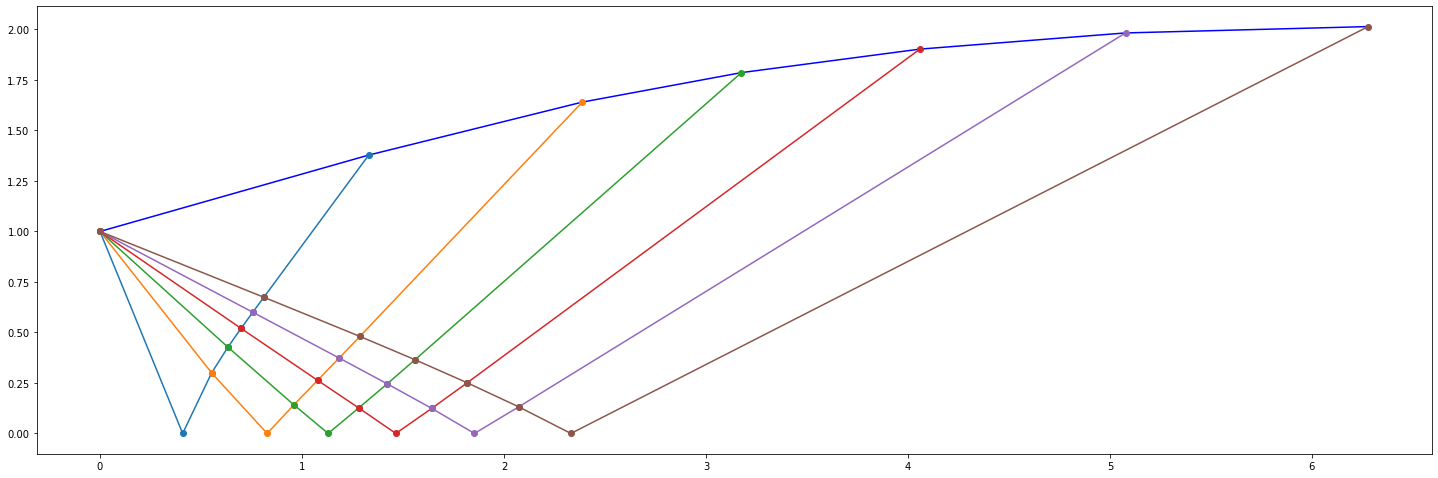

In [15]:
fig, ax = plt.subplots(figsize=(25,10))
plt.plot(xWall,yWall,"b")
plt.plot(xChar.T,yChar.T,"o-")
ax.set_aspect(1.0)
plt.show()